# Can we predict delinquencies based on loan data



I'll be using a dataset from Kaggle found here: <a href="https://www.kaggle.com/wendykan/lending-club-loan-data/download/wzLfTo5dSwyLukcTTrNF%2Fversions%2Fgi1Qzk701BksxlsurWD8%2Ffiles%2Floan.csv?datasetVersionNumber=1">This link will start a download if you are signed into Kaggle</a>

### Imports

The first thing we will do is import our libraries. 

I'll be using Pandas for Data Exploration. 
Numpy to manipulate the Data. 
Statsmodels to interpret my features usefulness in predicting.
And XGBoost to build a boosted forest model. (My computer can't handle regularly boosting on a dataset this size and I also normally receive better results from XGBoost models.)

In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

### Read in the Data:

In [2]:
data = pd.read_csv('./loan.csv', low_memory=False)

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.020000,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.110000,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,D

### Create DataFrame from columns we will be using:

I've selected columns based on perceived patterns I saw in the data. I wanted to remove anything that looked colinear and anything that was directly correlated with delinquency rates. Since that is what I am attempting to predict for.

In [4]:
df = data[['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'last_credit_pull_d', 'annual_inc_joint', 'dti_joint', 'delinq_2yrs']]

#### Separate the numerical values from columns that can be interpreted linearly

In [5]:
data_list = df['term'].str.split()
df['term'] = [i[0] for i in data_list]

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
data_list = df['emp_length']
new_data = []
for s in data_list:
    new_data.append([''.join(i for i in str(s) if i.isdigit())])
    
    

In [7]:
df['emp_length'] = [i[0] for i in new_data]

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,annual_inc_joint,dti_joint,delinq_2yrs
0,2500,36,13.56,84.92,C1,10,RENT,55000.0,Not Verified,Dec-2018,debt_consolidation,18.24,Apr-2001,1.0,9.0,1.0,4341,10.3,34.0,w,Feb-2019,NaN,NaN,0.0
1,30000,60,18.94,777.23,D2,10,MORTGAGE,90000.0,Source Verified,Dec-2018,debt_consolidation,26.52,Jun-1987,0.0,13.0,1.0,12315,24.2,44.0,w,Feb-2019,NaN,NaN,0.0
2,5000,36,17.97,180.69,D1,6,MORTGAGE,59280.0,Source Verified,Dec-2018,debt_consolidation,10.51,Apr-2011,0.0,8.0,0.0,4599,19.1,13.0,w,Feb-2019,NaN,NaN,0.0
3,4000,36,18.94,146.51,D2,10,MORTGAGE,92000.0,Source Verified,Dec-2018,debt_consolidation,16.74,Feb-2006,0.0,10.0,0.0,5468,78.1,13.0,w,Feb-2019,NaN,NaN,0.0
4,30000,60,16.14,731.78,C4,10,MORTGAGE,57250.0,Not Verified,Dec-2018,debt_consolidation,26.35,Dec-2000,0.0,12.0,0.0,829,3.6,26.0,w,Feb-2019,NaN,NaN,0.0


## I deleted unused information here
I only did this because my RAM was overwhelmed by the dataset. I'm running Ubuntu on 16GB RAM and I experience Kernel crashes when running calculations if I don't do this.

In [9]:
del data_list, new_data, data

## Binarize and get_dummies:

The next few sections is about handling my categorical data. I binarized verification status since it only has two values.

Got dummies for home ownership and purpose since there was few but multiple categories.

And I mapped the subgrade to integers since the values are hierarchical.

In [10]:
df['verification_status'] = [i[0] for i in df['verification_status'].str.split()]

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
df['verification_status'] = np.where(df['verification_status']=='Not', 0, 1)

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.drop('issue_d', axis=1, inplace=True)

/home/houston/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
df = pd.get_dummies(df, columns=['home_ownership', 'purpose'], drop_first=True)

In [14]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,verification_status,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,annual_inc_joint,dti_joint,delinq_2yrs,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,2500,36,13.56,84.92,C1,10,55000.0,0,18.24,Apr-2001,1.0,9.0,1.0,4341,10.3,34.0,w,Feb-2019,NaN,NaN,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,30000,60,18.94,777.23,D2,10,90000.0,1,26.52,Jun-1987,0.0,13.0,1.0,12315,24.2,44.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,5000,36,17.97,180.69,D1,6,59280.0,1,10.51,Apr-2011,0.0,8.0,0.0,4599,19.1,13.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,4000,36,18.94,146.51,D2,10,92000.0,1,16.74,Feb-2006,0.0,10.0,0.0,5468,78.1,13.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,30000,60,16.14,731.78,C4,10,57250.0,0,26.35,Dec-2000,0.0,12.0,0.0,829,3.6,26.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:
print(df['sub_grade'].unique())

['C1' 'D2' 'D1' 'C4' 'C3' 'C2' 'D5' 'B3' 'A4' 'B5' 'C5' 'D4' 'E1' 'E4'
 'B4' 'D3' 'A1' 'E5' 'B2' 'B1' 'A5' 'F5' 'A3' 'E3' 'A2' 'E2' 'F4' 'G1'
 'G2' 'F1' 'F2' 'F3' 'G4' 'G3' 'G5']


In [16]:
map_dict = {'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9, 'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14, 'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24, 'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29, 'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34}
df['sub_grade'] = df['sub_grade'].map(map_dict)

In [17]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,verification_status,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,annual_inc_joint,dti_joint,delinq_2yrs,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,2500,36,13.56,84.92,10,10,55000.0,0,18.24,Apr-2001,1.0,9.0,1.0,4341,10.3,34.0,w,Feb-2019,NaN,NaN,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,30000,60,18.94,777.23,16,10,90000.0,1,26.52,Jun-1987,0.0,13.0,1.0,12315,24.2,44.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,5000,36,17.97,180.69,15,6,59280.0,1,10.51,Apr-2011,0.0,8.0,0.0,4599,19.1,13.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,4000,36,18.94,146.51,16,10,92000.0,1,16.74,Feb-2006,0.0,10.0,0.0,5468,78.1,13.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,30000,60,16.14,731.78,13,10,57250.0,0,26.35,Dec-2000,0.0,12.0,0.0,829,3.6,26.0,w,Feb-2019,NaN,NaN,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Adjust DataTypes:
I had to convert DateTime into seconds and pass the string objects I made earlier into floats in order for the model to accept the data.

In [18]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

In [19]:
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])

In [20]:
df['initial_list_status'] = np.where(df['initial_list_status']=='w', 1, 0)

In [21]:
df['term'] = df['term'].astype(int)

In [22]:
df['emp_length'] = np.where(df['emp_length']== '', np.nan, df['emp_length'])

In [23]:
df['emp_length'] = df['emp_length'].astype(float)

## Next I handle Nulls:

I imputed 0 for employment lengths that were missing. This may not be accurate but it will help the classifier group those values.

I created a 'joint' column based on ```.notnull()``` values in annual_inc_joint. After creating this column I dropped both ```'dti_joint' and 'annual_inc_joint'```

I dropped the rows where ```delinq_2yrs``` was missing since that is the vale I am predicting for.

And imputed a 0 into the 1 missing value for ```inq_last_6mths```

In [24]:
df.isnull().sum()

loan_amnt                           0
term                                0
int_rate                            0
installment                         0
sub_grade                           0
emp_length                     146907
annual_inc                          4
verification_status                 0
dti                              1711
earliest_cr_line                   29
inq_last_6mths                     30
open_acc                           29
pub_rec                            29
revol_bal                           0
revol_util                       1802
total_acc                          29
initial_list_status                 0
last_credit_pull_d                 73
annual_inc_joint              2139958
dti_joint                     2139962
delinq_2yrs                        29
home_ownership_MORTGAGE             0
home_ownership_NONE                 0
home_ownership_OTHER                0
home_ownership_OWN                  0
home_ownership_RENT                 0
purpose_cred

In [25]:
df = df[df['delinq_2yrs'].notnull()]

In [26]:
df.isnull().sum()

loan_amnt                           0
term                                0
int_rate                            0
installment                         0
sub_grade                           0
emp_length                     146907
annual_inc                          0
verification_status                 0
dti                              1711
earliest_cr_line                    0
inq_last_6mths                      1
open_acc                            0
pub_rec                             0
revol_bal                           0
revol_util                       1773
total_acc                           0
initial_list_status                 0
last_credit_pull_d                 72
annual_inc_joint              2139929
dti_joint                     2139933
delinq_2yrs                         0
home_ownership_MORTGAGE             0
home_ownership_NONE                 0
home_ownership_OTHER                0
home_ownership_OWN                  0
home_ownership_RENT                 0
purpose_cred

In [27]:
df['joint'] = np.where(df['annual_inc_joint'], 1, 0)

In [28]:
df.drop(['annual_inc_joint', 'dti_joint'], axis=1, inplace=True)

In [29]:
df['emp_length'] = np.where(df['emp_length'].isnull(), 0, df['emp_length'])

In [30]:
df.drop(['dti', 'revol_util', 'last_credit_pull_d'], axis=1, inplace=True)

In [31]:
df['inq_last_6mths'] = np.where(df['inq_last_6mths'].isnull(), 0, df['inq_last_6mths'])

In [32]:
df['earliest_cr_line'] = [i.timestamp() for i in df['earliest_cr_line']]

## Train Test Split

Now That I've cleaned and formatted the data. I'm going to split and add a constant to my X

Then I will create a training and a testing set to fit my models too. 

And I will also delete the df from memory in order to prevent crashing.

In [33]:
X = df.drop('delinq_2yrs', axis=1)
X = sm.add_constant(X)
y = df['delinq_2yrs']
del df

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=42,
                                                   train_size =0.3)

### Poisson:

I'm fitting a poisson model so I can collect summary statistics. This allows me to gain a better understanding of how the model is interpreting the data and what features have the strongest correlation.

It also lets me know how statistically relevant the coefficient is.

In [54]:
poisson = sm.GLM(y_train, X_train,
                 family=sm.families.Poisson(sm.families.links.log)
                 ).fit()

/home/houston/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


In [55]:
poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            delinq_2yrs   No. Observations:               678191
Model:                            GLM   Df Residuals:                   678170
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.1160e+05
Date:                Mon, 03 Feb 2020   Deviance:                   7.3265e+05
Time:                        16:38:08   Pearson chi2:                 1.40e+10
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
loan_amnt                  -7.035e-06   1.74e-06     -4.041      0.000   -1.04e-05   -3.62e-06
term                          -0.0148      0.001    -29.196      0.000      -0.016      -0.014
int_rate                      -0.0446      0.002    -23.220      0.000      -0.048      -0.041
installment                  3.59e-05   5.45e-05      0.658      0.510    -7.1e-05       0.000
sub_grade                      0.0787      0.001     54.645      0.000       0.076       0.082
emp_length                     0.0117      0.001     19.949      0.000       0.011       0.013
annual_inc                   4.17e-07   8.81e-09     47.320      0.000       4e-07    4.34e-07
verification_status            0.0947      0.005     18.879      0.000       0.085       0.105
earliest_cr_line            -8.35e-10   8.74e-12    -95.482      0.000   -8.52e-10   -8.18e-10
inq_last_6mths                -0.0552      0.002    -22.299      0.000      -0.060      -0.050
open_acc                      -0.0138      0.001    -27.533      0.000      -0.015      -0.013
pub_rec                       -0.2927      0.005    -57.078      0.000      -0.303      -0.283
revol_bal                  -1.225e-05   1.76e-07    -69.657      0.000   -1.26e-05   -1.19e-05
total_acc                      0.0280      0.000    130.663      0.000       0.028       0.028
initial_list_status            0.1228      0.005     25.363      0.000       0.113       0.132
home_ownership_MORTGAGE        0.2184      0.110      1.977      0.048       0.002       0.435
home_ownership_NONE           -0.0069      0.461     -0.015      0.988      -0.910       0.896
home_ownership_OTHER           0.0431      0.250      0.173      0.863      -0.446       0.532
home_ownership_OWN             0.0829      0.111      0.749      0.454      -0.134       0.300
home_ownership_RENT           -0.0117      0.111     -0.106      0.916      -0.228       0.205
purpose_credit_card           -0.1368      0.021     -6.387      0.000      -0.179      -0.095
purpose_debt_consolidation    -0.0757      0.021     -3.599      0.000      -0.117      -0.034
purpose_educational           -0.8151      0.214     -3.801      0.000      -1.235      -0.395
purpose_home_improvement      -0.0066      0.022     -0.295      0.768      -0.050       0.037
purpose_house                  0.0274      0.033      0.825      0.409      -0.038       0.092
purpose_major_purchase        -0.0315      0.025     -1.245      0.213      -0.081       0.018
purpose_medical               -0.0897      0.028     -3.202      0.001      -0.145      -0.035
purpose_moving                 0.0516      0.032      1.618      0.106      -0.011       0.114
purpose_other                 -0.0777      0.022     -3.462      0.001      -0.122      -0.034
purpose_renewable_energy      -0.5117      

# Important features and notes from analysis:

The Status of home ownership seems to have the least influence on the overall number of predicted Delinquencies. We are also showing incredibly high P scores which indicates these results are not highly significant. Home Improvement projects, Moving, and Major purchases also have little significant impact on. The installment rate is also significant. Expect to influence overall model. There are many values that are showing 0 which is shows strong significant relationship.

<BarContainer object of 34 artists>

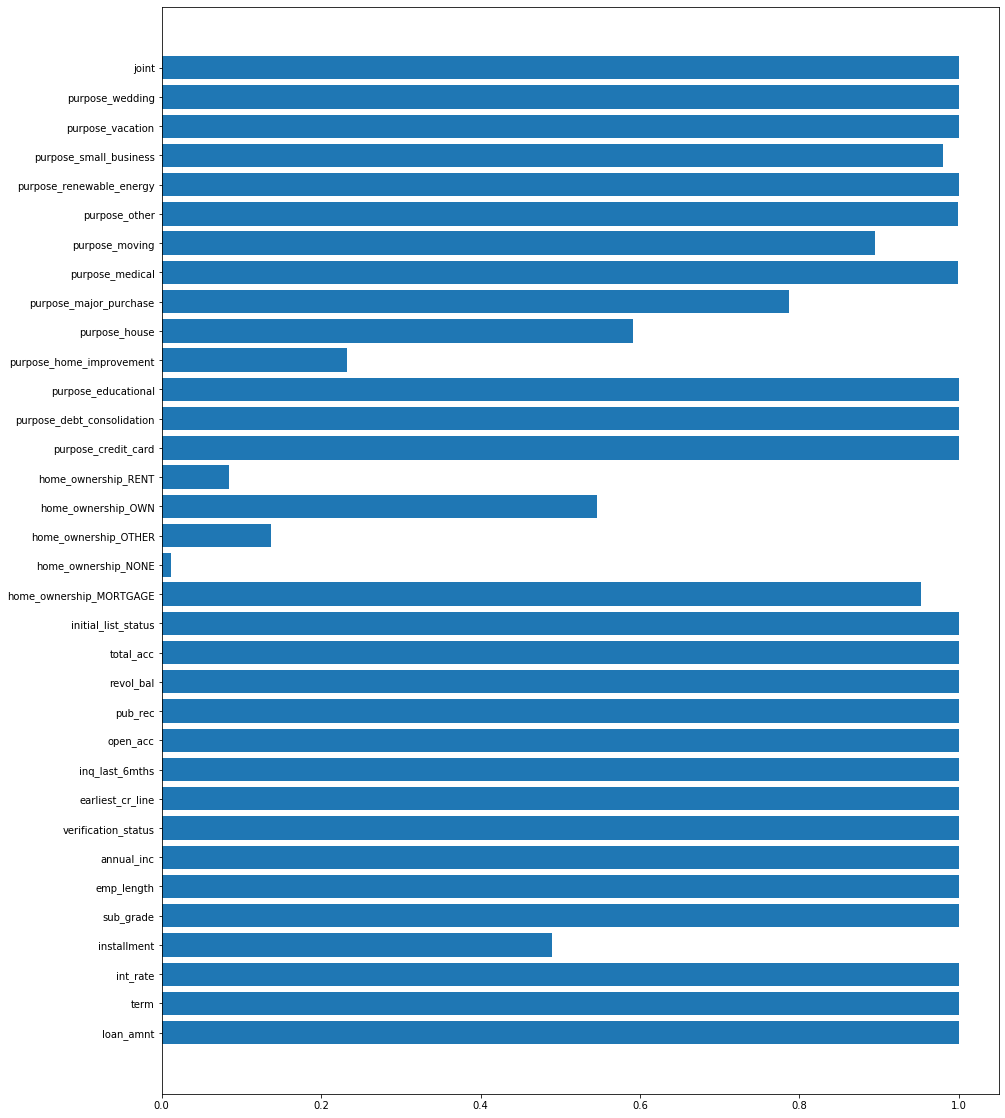

In [60]:
plt.figure(figsize=(15,20))
plt.barh(X_train.columns, width=1-poisson.pvalues)

In [37]:
del X, y, poisson

## Fitting for accuracy:

Now that I have an understanding of how the data is used to predict. I can see that there are in fact some fairly strong trends. I'll be starting by fitting my preferred "power" model. I'm going to fit XGBoostClassifier and test for accuracy in predictions. 

I'm guessing it will perform fairly well. Since there were strong trends noticed in the GLM. 

In [38]:
# xg = xgb.XGBClassifier(n_jobs=-1)

In [39]:
# xg.fit(X_train, y_train)

```XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)```

In [40]:
# xg.score(X_test, y_test)

0.8134753875008847

## Analyzing Results:

There aren't really many summary statistics we can collect from a black box model. However, it is important to check for improvement against baseline

In [41]:
# y_test.value_counts(normalize=True)

Results from ```y_test.value_counts(normalize=True)```
```
0.0     8.134754e-01
1.0     1.245090e-01
2.0     3.602077e-02
3.0     1.297863e-02
4.0     5.835368e-03
5.0     2.915841e-03
6.0     1.660297e-03
7.0     9.237797e-04
8.0     5.367212e-04
9.0     3.715762e-04
10.0    2.388704e-04
11.0    1.651450e-04
12.0    1.105882e-04
13.0    7.814896e-05
14.0    5.234506e-05
15.0    3.907448e-05
16.0    2.654116e-05
18.0    1.548234e-05
17.0    1.179607e-05
19.0    9.584307e-06
20.0    8.109798e-06
21.0    7.372543e-06
24.0    2.211763e-06
22.0    2.211763e-06
29.0    7.372543e-07
58.0    7.372543e-07
32.0    7.372543e-07
25.0    7.372543e-07
35.0    7.372543e-07
26.0    7.372543e-07
30.0    7.372543e-07
Name: delinq_2yrs, dtype: float64```

These results actually indicate we performed almost exactly at baseline:

This is not a desirable result.

Time to try different models.

#### ***I'm also commenting the cells out since XGBoost is a very long fitting model I don't want it to run every time I "Run All Above"***

In [42]:
# del xg

In [43]:
lr = LinearRegression(n_jobs=-1)

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [44]:
lr.score(X_test, y_test)

0.03284706992117148

In [45]:
del lr

### LogisticRegression performed poorly on this data

And as below so did Naive Bayes

In [52]:
mb = MultinomialNB()
mx = MinMaxScaler()
train_scale = mx.fit_transform(X_train)
mb.fit(train_scale, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
test_scale = mx.transform(X_test)
mb.score(test_scale, y_test)

0.8136627554270346

# Conclusions:

Naive Bayes offers no improvement over baseline.

With the models that I am able to fit in my timeline and using the data I have generated. I am unable to fit a model that beats baseline. 

If I had more time I would like to try using a Support Vector Model and adjusting the parameters in XGBoost. The max_depth was set by default to 3. But increasing it may give the model more ability to adjust to nuances in the data. 

There is also a probability that it is impossible to predict how often someone is delinquent on there payments by analyzing the data I have developed. 

Based on testing it would probably take a few more days in order to beat baseline accuracy by a substantial amount. Based on the results from the Poisson GLM there is definitely some strong correlations with many values. And I theorize that the tree depth isn't making these connections due to too many of the trees being based on extraneous values.

A more truncated Data Set or simply waiting to fit a more tuned model may be beneficial.